# Project Outlook
Looking to create a final best model for LDA, QDA, SVC, and SVM model types to predict 'Type' of cannabis strain in binary and multiclass settings. For SVM, I have limited myself to only the polynomial kernel.

For each model:

- Choose a metric for model selection

For my metric, I will be using the macro F1 score since it is a balanced metric that measures the mean of both precision and recall for each class and then averaged. This ensures that the performance on all classes is considered equal regardless of size.

- Find the best model for predicting the Type (strain) variable with any tuned hyperparameters.

- Report the (cross-validated!) metric.

- Fit the final model.

- Output a confusion matrix.

In [20]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

### Reading in data
This data contains information on cannabis strain reviews including strain, type, rating (0.0-5.0), effects, flavor, and dummy variables on whether the effect or flavor is present in the given strain.

In [21]:
data = pd.read_csv("C:/Users/alexa/OneDrive/Documentos/VSCode Folder/GSB544_Computing_and_ML/Data/Lab Data/cannabis_full.csv")
data.head()

,Strain,Type,Rating,Effects,Flavor,Creative,Energetic,Tingly,Euphoric,Relaxed,...,Ammonia,Minty,Tree,Fruit,Butter,Pineapple,Tar,Rose,Plum,Pear
0,100-Og,hybrid,4.0,"Creative,Energetic,Tingly,Euphoric,Relaxed","Earthy,Sweet,Citrus",1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,98-White-Widow,hybrid,4.7,"Relaxed,Aroused,Creative,Happy,Energetic","Flowery,Violet,Diesel",1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1024,sativa,4.4,"Uplifted,Happy,Relaxed,Energetic,Creative","Spicy/Herbal,Sage,Woody",1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,13-Dawgs,hybrid,4.2,"Tingly,Creative,Hungry,Relaxed,Uplifted","Apricot,Citrus,Grapefruit",1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,24K-Gold,hybrid,4.6,"Happy,Relaxed,Euphoric,Uplifted,Talkative","Citrus,Earthy,Orange",0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Seeing NA values

In [22]:
data_clean = data.dropna(subset=['Effects', 'Flavor'], how='any')
data_clean

,Strain,Type,Rating,Effects,Flavor,Creative,Energetic,Tingly,Euphoric,Relaxed,...,Ammonia,Minty,Tree,Fruit,Butter,Pineapple,Tar,Rose,Plum,Pear
0,100-Og,hybrid,4.0,"Creative,Energetic,Tingly,Euphoric,Relaxed","Earthy,Sweet,Citrus",1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,98-White-Widow,hybrid,4.7,"Relaxed,Aroused,Creative,Happy,Energetic","Flowery,Violet,Diesel",1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1024,sativa,4.4,"Uplifted,Happy,Relaxed,Energetic,Creative","Spicy/Herbal,Sage,Woody",1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,13-Dawgs,hybrid,4.2,"Tingly,Creative,Hungry,Relaxed,Uplifted","Apricot,Citrus,Grapefruit",1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,24K-Gold,hybrid,4.6,"Happy,Relaxed,Euphoric,Uplifted,Talkative","Citrus,Earthy,Orange",0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2346,Zeus-Og,hybrid,4.7,"Happy,Uplifted,Relaxed,Euphoric,Energetic","Earthy,Woody,Pine",0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2347,Zkittlez,indica,4.6,"Relaxed,Happy,Euphoric,Uplifted,Sleepy","Sweet,Berry,Grape",0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2348,Zombie-Kush,indica,5.0,"Relaxed,Sleepy,Talkative,Euphoric,Happy","Earthy,Sweet,Spicy/Herbal",0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2349,Zombie-Og,indica,4.4,"Relaxed,Sleepy,Euphoric,Happy,Hungry","Sweet,Earthy,Pungent",0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Part One: Binary Classification
Creating a dataset that is limited only to the Sativa and Indica type cannabis strains.

In [23]:
ind_sat = data_clean[(data_clean["Type"] == "indica") | (data_clean["Type"] == "sativa")]
ind_sat

,Strain,Type,Rating,Effects,Flavor,Creative,Energetic,Tingly,Euphoric,Relaxed,...,Ammonia,Minty,Tree,Fruit,Butter,Pineapple,Tar,Rose,Plum,Pear
2,1024,sativa,4.4,"Uplifted,Happy,Relaxed,Energetic,Creative","Spicy/Herbal,Sage,Woody",1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,303-Og,indica,4.2,"Relaxed,Happy,Euphoric,Uplifted,Giggly","Citrus,Pungent,Earthy",0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,3D-Cbd,sativa,4.6,"Uplifted,Focused,Happy,Talkative,Relaxed","Earthy,Woody,Flowery",0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,3X-Crazy,indica,4.4,"Relaxed,Tingly,Happy,Euphoric,Uplifted","Earthy,Grape,Sweet",0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,5Th-Element,indica,4.4,"Relaxed,Focused,Euphoric,Uplifted,Aroused","Earthy,Woody,Pine",0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2345,Zeta-Sage,sativa,4.5,"Happy,Relaxed,Uplifted,Euphoric,Focused","Diesel,Pungent,Sage",0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2347,Zkittlez,indica,4.6,"Relaxed,Happy,Euphoric,Uplifted,Sleepy","Sweet,Berry,Grape",0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2348,Zombie-Kush,indica,5.0,"Relaxed,Sleepy,Talkative,Euphoric,Happy","Earthy,Sweet,Spicy/Herbal",0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2349,Zombie-Og,indica,4.4,"Relaxed,Sleepy,Euphoric,Happy,Hungry","Sweet,Earthy,Pungent",0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
print(ind_sat.dtypes)

Strain        object
Type          object
Rating       float64
Effects       object
Flavor        object
              ...   
Pineapple    float64
Tar          float64
Rose         float64
Plum         float64
Pear         float64
Length: 69, dtype: object


### LDA Model

In [25]:
X = ind_sat.drop(columns=['Type', 'Strain', 'Effects', 'Flavor'], axis = 1)
y = ind_sat['Type']

lda_pipeline = Pipeline(
    [('lda', LinearDiscriminantAnalysis())]
)

param_grid = {
    'lda__solver': ['svd', 'lsqr', 'eigen'],  # Solver options
    'lda__shrinkage': [None, 'auto', 0.1, 0.5, 1.0],  # Shrinkage (only for lsqr or eigen solvers)
}

fitted_lda = lda_pipeline.fit(X, y)

gscv = GridSearchCV(lda_pipeline, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)

# Fit the grid search
gscv_fitted = gscv.fit(X, y)

# Extract the best parameters and scores
print("Best Parameters:", gscv_fitted.best_params_)
print("Best F1 Macro Score:", gscv_fitted.best_score_)

Best Parameters: {'lda__shrinkage': 0.5, 'lda__solver': 'lsqr'}
Best F1 Macro Score: 0.8623038178832413


##### Final LDA Model and confusion matrix

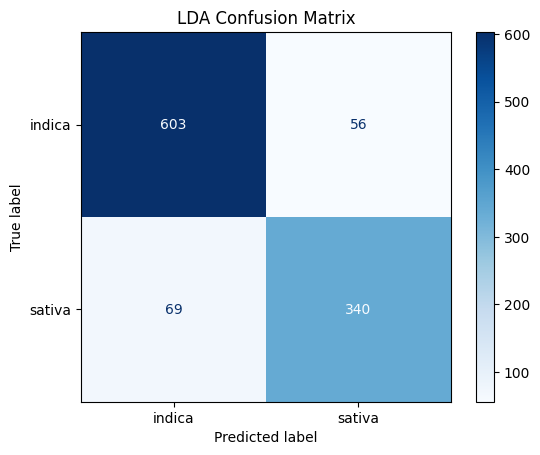

In [26]:
lda_pipeline = Pipeline(
    [('lda', LinearDiscriminantAnalysis(
        solver = 'lsqr',
        shrinkage = 0.5
    ))]
)

fitted_lda = lda_pipeline.fit(X, y)

y_pred = fitted_lda.predict(X)

cm = confusion_matrix(y, y_pred, labels=lda_pipeline.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lda_pipeline.classes_)
disp.plot(cmap='Blues')
plt.title("LDA Confusion Matrix")
plt.show()

### QDA Model

In [27]:
qda_pipeline = Pipeline(
    [('qda', QuadraticDiscriminantAnalysis())]
)

param_grid = {
    'qda__reg_param': [0.0, 0.1, 0.5, 1.0],  # Regularization parameters
    'qda__store_covariance': [True, False],  # Option to store covariance matrices
    'qda__tol': [1e-4, 1e-3, 1e-2],         # Tolerance for SVD
}

# Perform grid search with cross-validation
gscv = GridSearchCV(qda_pipeline, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)

# Fit the grid search to the data
gscv_fitted = gscv.fit(X, y)

# Extract the best parameters and scores
print("Best Parameters:", gscv_fitted.best_params_)
print("Best F1 Macro Score:", gscv_fitted.best_score_)

Best Parameters: {'qda__reg_param': 0.1, 'qda__store_covariance': True, 'qda__tol': 0.0001}
Best F1 Macro Score: 0.8574088072773802


##### Final QDA Model and confusion matrix

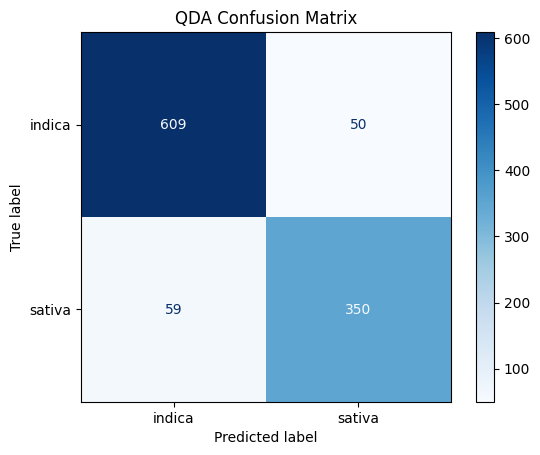

In [28]:
qda_pipeline = Pipeline(
    [('qda', QuadraticDiscriminantAnalysis(
        reg_param = 0.1,
        store_covariance = True,
        tol = 0.0001
    ))]
)

fitted_qda = qda_pipeline.fit(X, y)

y_pred = fitted_qda.predict(X)

cm = confusion_matrix(y, y_pred, labels=qda_pipeline.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=qda_pipeline.classes_)
disp.plot(cmap='Blues')
plt.title("QDA Confusion Matrix")
plt.show()

### SVC Model

In [29]:
svc_pipeline = Pipeline(
    [('svc', SVC())]
)

# Define the parameter grid for SVC
param_grid = {
    'svc__C': [0.1, 1, 10, 100],                # Regularization parameter
    'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Kernel type
    'svc__gamma': ['scale', 'auto', 0.1, 1, 10],          # Kernel coefficient
    'svc__degree': [2, 3, 4],                   # Degree of the polynomial kernel (only for 'poly')
    'svc__class_weight': [None, 'balanced'],    # Handle class imbalance
}

# Perform grid search with cross-validation
gscv = GridSearchCV(svc_pipeline, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)

# Fit the grid search to the data
gscv_fitted = gscv.fit(X, y)

# Extract the best parameters and scores
print("Best Parameters:", gscv_fitted.best_params_)
print("Best F1 Macro Score:", gscv_fitted.best_score_)

Best Parameters: {'svc__C': 0.1, 'svc__class_weight': 'balanced', 'svc__degree': 2, 'svc__gamma': 'scale', 'svc__kernel': 'linear'}
Best F1 Macro Score: 0.8714114955320778


##### Final SVC Model and confusion matrix

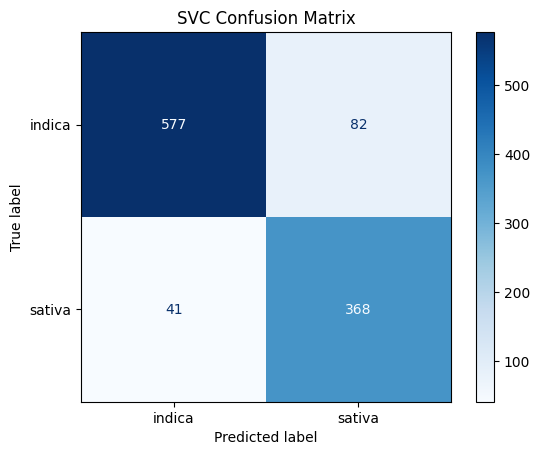

In [30]:
svc_pipeline = Pipeline(
    [('svc', SVC(
        C = 0.1,
        kernel = 'linear',
        gamma ='scale',
        degree = 2,
        class_weight = 'balanced'
    ))]
)

fitted_svc = svc_pipeline.fit(X, y)

y_pred = fitted_svc.predict(X)

cm = confusion_matrix(y, y_pred, labels=svc_pipeline.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svc_pipeline.classes_)
disp.plot(cmap='Blues')
plt.title("SVC Confusion Matrix")
plt.show()



### SVM Model

In [31]:
svm_pipeline = Pipeline(
    [('svm', SVC())]
)

# Define the parameter grid for SVC
param_grid = {
    'svm__C': [0.1, 1, 10, 100],                # Regularization parameter
    'svm__kernel': ['poly'],  # Kernel type
    'svm__gamma': ['scale', 'auto', 0.1, 1, 10],          # Kernel coefficient
    'svm__degree': [2, 3, 4],                   # Degree of the polynomial kernel (only for 'poly')
    'svm__class_weight': [None, 'balanced'],    # Handle class imbalance
}

# Perform grid search with cross-validation
gscv = GridSearchCV(svm_pipeline, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)

# Fit the grid search to the data
gscv_fitted = gscv.fit(X, y)

# Extract the best parameters and scores
print("Best Parameters:", gscv_fitted.best_params_)
print("Best F1 Macro Score:", gscv_fitted.best_score_)

Best Parameters: {'svm__C': 1, 'svm__class_weight': 'balanced', 'svm__degree': 2, 'svm__gamma': 'scale', 'svm__kernel': 'poly'}
Best F1 Macro Score: 0.8694222657040539


##### Final SVM Model and confusion matrix

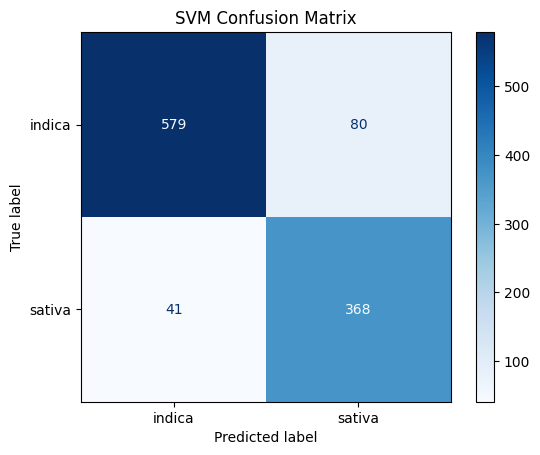

In [32]:
svm_pipeline = Pipeline(
    [('svm', SVC(
        C = 1,
        kernel = 'poly',
        gamma ='scale',
        degree = 2,
        class_weight = 'balanced'
    ))]
)

fitted_svm = svm_pipeline.fit(X, y)

y_pred = fitted_svm.predict(X)

cm = confusion_matrix(y, y_pred, labels=svm_pipeline.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_pipeline.classes_)
disp.plot(cmap='Blues')
plt.title("SVM Confusion Matrix")
plt.show()

# Part Two: Natural Multiclass
### Now we are using the full dataset, including the Hybrid strains.

#### Fitting a decision tree, plotting the final fit, and interpretting the results.

In [33]:
X = data_clean.drop(columns=['Type', 'Strain', 'Effects', 'Flavor'], axis = 1)
y = data_clean['Type']

dt_pipeline = Pipeline(
    [
     ("dt", DecisionTreeClassifier())]
)

param_grid = {
    'dt__max_depth': list(range(0, 50))     # Handle class imbalance
}

# Perform grid search with cross-validation
gscv = GridSearchCV(dt_pipeline, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)

# Fit the grid search to the data
gscv_fitted = gscv.fit(X, y)

# Extract the best parameters and scores
print("Best Parameters:", gscv_fitted.best_params_)
print("Best F1 Macro Score:", gscv_fitted.best_score_)

Best Parameters: {'dt__max_depth': 3}
Best F1 Macro Score: 0.5848756063204548


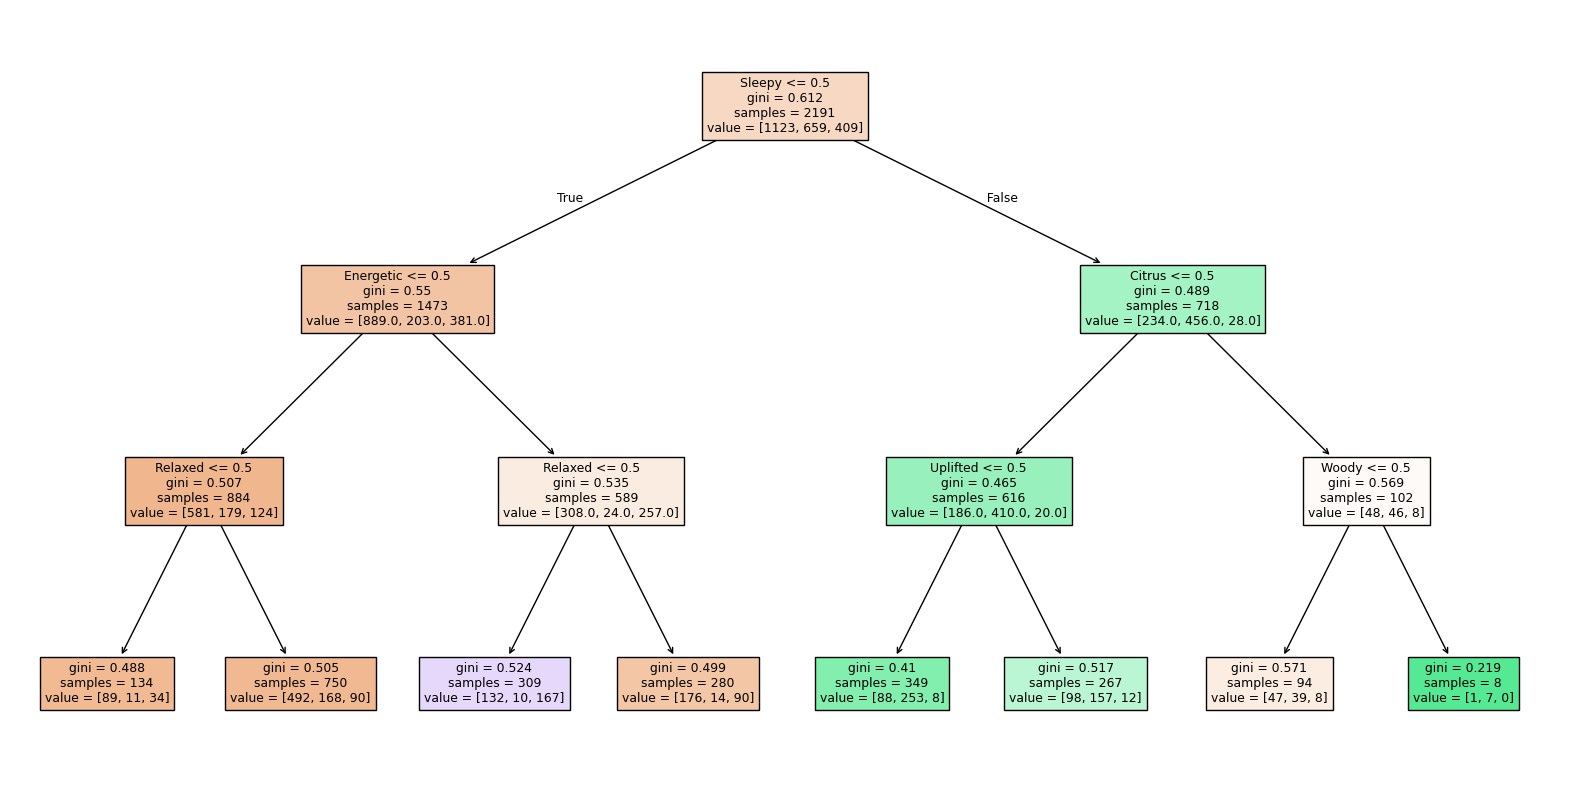

In [34]:
plt.figure(figsize=(20,10))
plot_tree(DecisionTreeClassifier(max_depth=3).fit(X,y), filled= True, feature_names = X.columns.to_list())
plt.show()

In [35]:
clf = DecisionTreeClassifier(max_depth=3)
clf.fit(X, y)

# Get the order of classes
print("Class Order:", clf.classes_)

Class Order: ['hybrid' 'indica' 'sativa']


#### Decision Tree analysis

The root node of this decision tree is the effect of Sleepy for all 2191 strains of the cleaned data set. If an observation has a less than or equal to 50% chance of being Sleepy, it goes to the next node of Energetic, and if not, it goes to the node of Citrus flavor. At each node, the class prediction is based on the majority class in the value field. For example, in the Relaxed node to the left of the tree, the majority class is hybrid which means that if there is a less than or equal to 50% that a strain makes you feel sleepy and energetic, this means that it is likely a hybrid. The color of each node also represents the class majority and the intensity of how much that class is in each node, also shown by the gini. One major takeaway is that there are not many sativa strains in this dataset since there is only one purple node and its gini is on the higher side compared to other nodes meaning that it is not very pure. The tree seems best at predicting hybrids since there are intensely colored tan nodes at the bottom of the tree, and second best at predicting sativas. This makes sense due to the number of hybrids, indicas, and sativas relative to the entire dataset. 

### Repeated analyses from Part One for LDA, QDA, and KNN.

#### LDA plus hybrid

In [36]:
X = data_clean.drop(columns=['Type', 'Strain', 'Effects', 'Flavor'], axis = 1)
y = data_clean['Type']

lda_pipeline = Pipeline(
    [('lda', LinearDiscriminantAnalysis())]
)

param_grid = {
    'lda__solver': ['svd', 'lsqr', 'eigen'],  # Solver options
    'lda__shrinkage': [None, 'auto', 0.1, 0.5, 1.0],  # Shrinkage (only for lsqr or eigen solvers)
}

fitted_lda = lda_pipeline.fit(X, y)

gscv = GridSearchCV(fitted_lda, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)

# Fit the grid search
gscv_fitted = gscv.fit(X, y)

# Extract the best parameters and scores
print("Best Parameters:", gscv_fitted.best_params_)
print("Best F1 Macro Score:", gscv_fitted.best_score_)

Best Parameters: {'lda__shrinkage': 0.5, 'lda__solver': 'lsqr'}
Best F1 Macro Score: 0.6007600257421012


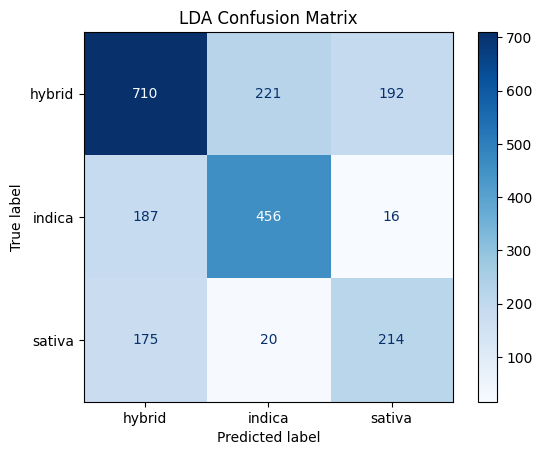

In [37]:
X = data_clean.drop(columns=['Type', 'Strain', 'Effects', 'Flavor'], axis = 1)
y = data_clean['Type']

lda_pipeline = Pipeline(
    [('lda', LinearDiscriminantAnalysis(
        solver = 'lsqr',
        shrinkage = 0.5
    ))]
)

fitted_lda = lda_pipeline.fit(X, y)

y_pred = fitted_lda.predict(X)

cm = confusion_matrix(y, y_pred, labels=lda_pipeline.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lda_pipeline.classes_)
disp.plot(cmap='Blues')
plt.title("LDA Confusion Matrix")
plt.show()

#### QDA plus hybrid

In [38]:
X = data_clean.drop(columns=['Type', 'Strain', 'Effects', 'Flavor'], axis = 1)
y = data_clean['Type']

qda_pipeline = Pipeline(
    [('qda', QuadraticDiscriminantAnalysis())]
)

param_grid = {
    'qda__reg_param': [0.1, 0.2, 0.5, 1.0],  # Regularization parameters
    'qda__store_covariance': [True, False],  # Option to store covariance matrices
    'qda__tol': [1e-7, 1e-5, 1e-4, 1e-3, 1e-2]         # Tolerance for SVD
}

fitted_qda = qda_pipeline.fit(X, y)

# Perform grid search with cross-validation
gscv = GridSearchCV(fitted_qda, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)

# Fit the grid search to the data
gscv_fitted = gscv.fit(X, y)

# Extract the best parameters and scores
print("Best Parameters:", gscv_fitted.best_params_)
print("Best F1 Macro Score:", gscv_fitted.best_score_)

Best Parameters: {'qda__reg_param': 0.1, 'qda__store_covariance': True, 'qda__tol': 1e-07}
Best F1 Macro Score: 0.572693676291743


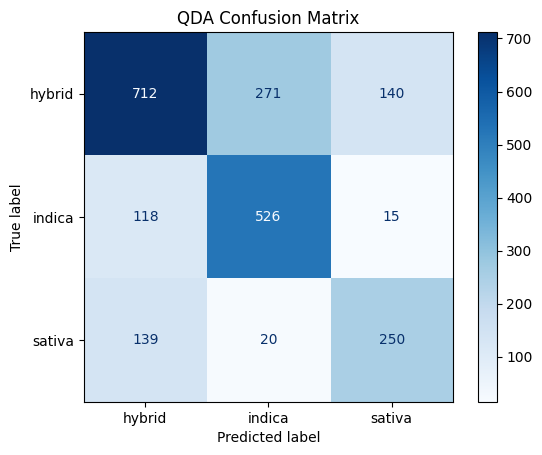

In [39]:
X = data_clean.drop(columns=['Type', 'Strain', 'Effects', 'Flavor'], axis = 1)
y = data_clean['Type']

qda_pipeline = Pipeline(
    [('qda', QuadraticDiscriminantAnalysis(
        reg_param = 0.1, 
        store_covariance = True,
        tol = 1e-7
    ))]
)

fitted_qda = qda_pipeline.fit(X, y)

y_pred = fitted_qda.predict(X)

cm = confusion_matrix(y, y_pred, labels=qda_pipeline.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=qda_pipeline.classes_)
disp.plot(cmap='Blues')
plt.title("QDA Confusion Matrix")
plt.show()

#### KNN plus hybrid

In [40]:
X = data_clean.drop(columns=['Type', 'Strain', 'Effects', 'Flavor'], axis = 1)
y = data_clean['Type']

knn_pipeline = Pipeline(
    [('knn', KNeighborsClassifier())]
)

# Define the parameter grid for KNN
param_grid = {
    'knn__n_neighbors': list(range(0, 25)),           # Number of neighbors to use
    'knn__weights': ['uniform', 'distance'],     # Weight function for neighbors
    'knn__metric': ['euclidean', 'manhattan', 'minkowski'],  # Distance metric                   
}

# Perform grid search with cross-validation
gscv = GridSearchCV(knn_pipeline, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)

# Fit the grid search to the data
gscv_fitted = gscv.fit(X, y)

# Extract the best parameters and scores
print("Best Parameters:", gscv_fitted.best_params_)
print("Best F1 Macro Score:", gscv_fitted.best_score_)

Best Parameters: {'knn__metric': 'euclidean', 'knn__n_neighbors': 19, 'knn__weights': 'distance'}
Best F1 Macro Score: 0.5419703360062768


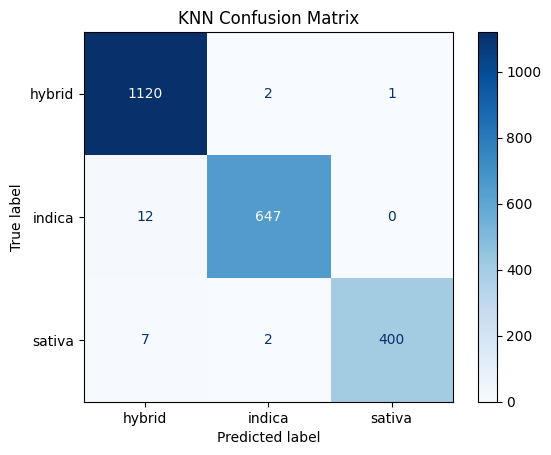

In [41]:
X = data_clean.drop(columns=['Type', 'Strain', 'Effects', 'Flavor'], axis = 1)
y = data_clean['Type']

knn_pipeline = Pipeline(
    [('knn', KNeighborsClassifier(
        n_neighbors = 19,
        weights = 'distance',
        metric = 'euclidean'
    ))]
)

fitted_knn = knn_pipeline.fit(X, y)

y_pred = fitted_knn.predict(X)

cm = confusion_matrix(y, y_pred, labels=knn_pipeline.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn_pipeline.classes_)
disp.plot(cmap='Blues')
plt.title("KNN Confusion Matrix")
plt.show()

### Comparison of metrics between part 1 and 2

All macro F1 scores were worse than in Part Two besides the KNN model. This is because the addition of the hybrid category to the data set created a larger imbalance due to it being the dominant category amongst the three. There is also increased complexity overall with the addition of the hybrid, and the tuned/fitted models from Part One are according to sative and indica strains only, not with all three strains. According to the Part One LDA and QDA confucion matrices, both models incorrectly predicted a few more sativas as indicas than indicas as sativas, however both models equally misclassified both strains for the most part. For the LDA and QDA models in Part Two, sativa and hybrid seemed to be mixed up the most with sativas being perceived as hybrids and hybrids being perceived as indicas. This is likely because there is, again, an imbalance with sativas having the smallest number of observations and hybrids having the most number of observations. It makes sense that there would be more mix up overall with hybrids since the models are not tuned to include hybrids, and there are simply more hybrid strains in the data set.

# Part Three: Multiclass from Binary
Considering two models designed for binary classification: SVC and Logistic Regression.

Fit and report metrics for **One versus Rest** versions of the models. That is, for each of the two model types, three models below were created:



Creating three new variables for is_indica, is_hybrid, and is_sativa

In [42]:
data_clean['is_hybrid'] = np.where(data_clean['Type'] == 'hybrid', 1, 0)
data_clean['is_indica'] = np.where(data_clean['Type'] == 'indica', 1, 0)
data_clean['is_sativa'] = np.where(data_clean['Type'] == 'sativa', 1, 0)

#### Indica vs. Not Indica SVC

In [46]:
X = data_clean.drop(columns=['Type', 'Strain', 'Effects', 'Flavor', 'is_indica', 'is_hybrid', 'is_sativa'], axis = 1)
y = data_clean['is_indica']

svc_pipeline = Pipeline(
    [('svc', SVC())]
)

# Define the parameter grid for SVC
param_grid = {
    'svc__C': [10, 100, 1000],                # Regularization parameter
    'svc__kernel': ['linear'],  # Kernel type
    'svc__gamma': ['scale', 'auto', 0.1, 1, 10],          # Kernel coefficient         
    'svc__class_weight': [None, 'balanced'],    # Handle class imbalance
    'svc__max_iter': [1000, 5000, -1]
}

# Perform grid search with cross-validation
gscv = GridSearchCV(svc_pipeline, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)

# Fit the grid search to the data
gscv_fitted = gscv.fit(X, y)

# Extract the best parameters and scores
print("Best Parameters:", gscv_fitted.best_params_)
print("Best F1 Macro Score:", gscv_fitted.best_score_)

Best Parameters: {'svc__C': 1000, 'svc__class_weight': None, 'svc__gamma': 'scale', 'svc__kernel': 'linear', 'svc__max_iter': -1}
Best F1 Macro Score: 0.7546110122517156


#### Indica vs. Not Indica Logistic Regression

In [47]:
X = data_clean.drop(columns=['Type', 'Strain', 'Effects', 'Flavor', 'is_indica', 'is_hybrid', 'is_sativa'], axis = 1)
y = data_clean['is_indica']

import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

logreg_pipeline = Pipeline(
    [('logreg', LogisticRegression(max_iter=5000))]
)

param_grid = {
    'logreg__C': [0.01, 0.1, 1, 10, 100],       # Inverse of regularization strength
    'logreg__penalty': ['l1', 'elasticnet', 'none'],  # Type of regularization
    'logreg__solver': ['saga', 'lbfgs', 'liblinear'],       # Solver
    'logreg__class_weight': [None, 'balanced'],             # Handle class imbalance
    'logreg__l1_ratio': [0.1, 0.5, 0.7, 0.9],               # Only for elasticnet penalty
}

# Perform grid search with cross-validation
gscv = GridSearchCV(logreg_pipeline, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)

# Fit the grid search to the data
gscv_fitted = gscv.fit(X, y)

# Extract the best parameters and scores
print("Best Parameters:", gscv_fitted.best_params_)
print("Best F1 Macro Score:", gscv_fitted.best_score_)

Best Parameters: {'logreg__C': 0.1, 'logreg__class_weight': None, 'logreg__l1_ratio': 0.5, 'logreg__penalty': 'elasticnet', 'logreg__solver': 'saga'}
Best F1 Macro Score: 0.7590680272859012


#### Sativa vs. Not Sativa SVC

In [48]:
X = data_clean.drop(columns=['Type', 'Strain', 'Effects', 'Flavor', 'is_indica', 'is_hybrid', 'is_sativa'], axis = 1)
y = data_clean['is_sativa']

svc_pipeline = Pipeline(
    [('svc', SVC())]
)

# Define the parameter grid for SVC
param_grid = {
    'svc__C': [10, 100, 1000],                # Regularization parameter
    'svc__kernel': ['linear'],  # Kernel type
    'svc__gamma': ['scale', 'auto', 0.1, 1, 10],          # Kernel coefficient         
    'svc__class_weight': [None, 'balanced'],    # Handle class imbalance
    'svc__max_iter': [1000, 5000, -1]
}

# Perform grid search with cross-validation
gscv = GridSearchCV(svc_pipeline, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)

# Fit the grid search to the data
gscv_fitted = gscv.fit(X, y)

# Extract the best parameters and scores
print("Best Parameters:", gscv_fitted.best_params_)
print("Best F1 Macro Score:", gscv_fitted.best_score_)

Best Parameters: {'svc__C': 10, 'svc__class_weight': 'balanced', 'svc__gamma': 'scale', 'svc__kernel': 'linear', 'svc__max_iter': -1}
Best F1 Macro Score: 0.6623086480762624


#### Sativa vs. Not Sativa Logistic Regression

In [49]:
X = data_clean.drop(columns=['Type', 'Strain', 'Effects', 'Flavor', 'is_indica', 'is_hybrid', 'is_sativa'], axis = 1)
y = data_clean['is_sativa']

import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

logreg_pipeline = Pipeline(
    [('logreg', LogisticRegression(max_iter=5000))]
)

param_grid = {
    'logreg__C': [0.01, 0.1, 1, 10, 100],       # Inverse of regularization strength
    'logreg__penalty': ['l1', 'elasticnet', 'none'],  # Type of regularization
    'logreg__solver': ['saga', 'lbfgs', 'liblinear'],       # Solver
    'logreg__class_weight': [None, 'balanced'],             # Handle class imbalance
    'logreg__l1_ratio': [0.1, 0.5, 0.7, 0.9],               # Only for elasticnet penalty
}

# Perform grid search with cross-validation
gscv = GridSearchCV(logreg_pipeline, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)

# Fit the grid search to the data
gscv_fitted = gscv.fit(X, y)

# Extract the best parameters and scores
print("Best Parameters:", gscv_fitted.best_params_)
print("Best F1 Macro Score:", gscv_fitted.best_score_)

Best Parameters: {'logreg__C': 0.01, 'logreg__class_weight': 'balanced', 'logreg__l1_ratio': 0.1, 'logreg__penalty': 'l1', 'logreg__solver': 'saga'}
Best F1 Macro Score: 0.6758859654508034


#### Hybrid vs. Not Hybrid SVC

In [50]:
X = data_clean.drop(columns=['Type', 'Strain', 'Effects', 'Flavor', 'is_indica', 'is_hybrid', 'is_sativa'], axis = 1)
y = data_clean['is_hybrid']

svc_pipeline = Pipeline(
    [('svc', SVC())]
)

# Define the parameter grid for SVC
param_grid = {
    'svc__C': [10, 100, 1000],                # Regularization parameter
    'svc__kernel': ['linear'],  # Kernel type
    'svc__gamma': ['scale', 'auto', 0.1, 1, 10],          # Kernel coefficient         
    'svc__class_weight': [None, 'balanced'],    # Handle class imbalance
    'svc__max_iter': [1000, 5000, -1]
}

# Perform grid search with cross-validation
gscv = GridSearchCV(svc_pipeline, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)

# Fit the grid search to the data
gscv_fitted = gscv.fit(X, y)

# Extract the best parameters and scores
print("Best Parameters:", gscv_fitted.best_params_)
print("Best F1 Macro Score:", gscv_fitted.best_score_)

Best Parameters: {'svc__C': 10, 'svc__class_weight': None, 'svc__gamma': 'scale', 'svc__kernel': 'linear', 'svc__max_iter': -1}
Best F1 Macro Score: 0.6125127745745085


#### Hybrid vs. Not Hybrid Logistic Regression

In [51]:
X = data_clean.drop(columns=['Type', 'Strain', 'Effects', 'Flavor', 'is_indica', 'is_hybrid', 'is_sativa'], axis = 1)
y = data_clean['is_hybrid']

import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

logreg_pipeline = Pipeline(
    [('logreg', LogisticRegression(max_iter=5000))]
)

param_grid = {
    'logreg__C': [0.01, 0.1, 1, 10, 100],       # Inverse of regularization strength
    'logreg__penalty': ['l1', 'elasticnet', 'none'],  # Type of regularization
    'logreg__solver': ['saga', 'lbfgs', 'liblinear'],       # Solver
    'logreg__class_weight': [None, 'balanced'],             # Handle class imbalance
    'logreg__l1_ratio': [0.1, 0.5, 0.7, 0.9],               # Only for elasticnet penalty
}

# Perform grid search with cross-validation
gscv = GridSearchCV(logreg_pipeline, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)

# Fit the grid search to the data
gscv_fitted = gscv.fit(X, y)

# Extract the best parameters and scores
print("Best Parameters:", gscv_fitted.best_params_)
print("Best F1 Macro Score:", gscv_fitted.best_score_)

Best Parameters: {'logreg__C': 0.1, 'logreg__class_weight': None, 'logreg__l1_ratio': 0.5, 'logreg__penalty': 'elasticnet', 'logreg__solver': 'saga'}
Best F1 Macro Score: 0.622952552638156


### Part Three Model Analysis


The indica versus not indica logistic regression did the best job distinguishing the target category from the rest. The hybrid versus not hybrid SVC did the worst job at distinguishing the target category from the rest. It makes sense that hybrid versus not hybrid SVC did the worst since hybrid is the stain with the most observations, so there are less observations to predict out of sativa and indica. The difference between SVC and logistic regression for hybrid versus not hybrid is not very significant. It makes sense that the indica versus not indica logistic regression would have the highest F1 macro score since it is a balanced amount of observations between hybrid (most frequent class) and sativa (least frequent class) observations to predict indica. 

### Fitting/reporting metrics for One versus One versions of the models. For each of the two model types, the below three models were created:

#### Indica vs. Sativa SVC

In [52]:
ind_sat['is_hybrid'] = np.where(ind_sat['Type'] == 'hybrid', 1, 0)
ind_sat['is_indica'] = np.where(ind_sat['Type'] == 'indica', 1, 0)
ind_sat['is_sativa'] = np.where(ind_sat['Type'] == 'sativa', 1, 0)
ind_sat

,Strain,Type,Rating,Effects,Flavor,Creative,Energetic,Tingly,Euphoric,Relaxed,...,Fruit,Butter,Pineapple,Tar,Rose,Plum,Pear,is_hybrid,is_indica,is_sativa
2,1024,sativa,4.4,"Uplifted,Happy,Relaxed,Energetic,Creative","Spicy/Herbal,Sage,Woody",1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1
7,303-Og,indica,4.2,"Relaxed,Happy,Euphoric,Uplifted,Giggly","Citrus,Pungent,Earthy",0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
8,3D-Cbd,sativa,4.6,"Uplifted,Focused,Happy,Talkative,Relaxed","Earthy,Woody,Flowery",0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1
9,3X-Crazy,indica,4.4,"Relaxed,Tingly,Happy,Euphoric,Uplifted","Earthy,Grape,Sweet",0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
12,5Th-Element,indica,4.4,"Relaxed,Focused,Euphoric,Uplifted,Aroused","Earthy,Woody,Pine",0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2345,Zeta-Sage,sativa,4.5,"Happy,Relaxed,Uplifted,Euphoric,Focused","Diesel,Pungent,Sage",0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1
2347,Zkittlez,indica,4.6,"Relaxed,Happy,Euphoric,Uplifted,Sleepy","Sweet,Berry,Grape",0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
2348,Zombie-Kush,indica,5.0,"Relaxed,Sleepy,Talkative,Euphoric,Happy","Earthy,Sweet,Spicy/Herbal",0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
2349,Zombie-Og,indica,4.4,"Relaxed,Sleepy,Euphoric,Happy,Hungry","Sweet,Earthy,Pungent",0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0


In [53]:
X = ind_sat.drop(columns=['Type', 'Strain', 'Effects', 'Flavor', 'is_indica', 'is_hybrid', 'is_sativa'], axis = 1)
y = ind_sat['is_sativa']

svc_pipeline = Pipeline(
    [('svc', SVC())]
)

# Define the parameter grid for SVC
param_grid = {
    'svc__C': [10, 100, 1000],                # Regularization parameter
    'svc__kernel': ['linear'],  # Kernel type
    'svc__gamma': ['scale', 'auto', 0.1, 1, 10],          # Kernel coefficient         
    'svc__class_weight': [None, 'balanced'],    # Handle class imbalance
    'svc__max_iter': [1000, 5000, -1]
}

# Perform grid search with cross-validation
gscv = GridSearchCV(svc_pipeline, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)

# Fit the grid search to the data
gscv_fitted = gscv.fit(X, y)

# Extract the best parameters and scores
print("Best Parameters:", gscv_fitted.best_params_)
print("Best F1 Macro Score:", gscv_fitted.best_score_)

Best Parameters: {'svc__C': 10, 'svc__class_weight': None, 'svc__gamma': 'scale', 'svc__kernel': 'linear', 'svc__max_iter': 5000}
Best F1 Macro Score: 0.8482586054591753


#### Indica vs. Sativa Logistic Regression


In [54]:
X = ind_sat.drop(columns=['Type', 'Strain', 'Effects', 'Flavor', 'is_indica', 'is_hybrid', 'is_sativa'], axis = 1)
y = ind_sat['is_sativa']

logreg_pipeline = Pipeline(
    [('logreg', LogisticRegression(max_iter=5000))]
)

param_grid = {
    'logreg__C': [0.01, 0.1, 1, 10, 100],       # Inverse of regularization strength
    'logreg__penalty': ['l1', 'elasticnet', 'none'],  # Type of regularization
    'logreg__solver': ['saga', 'lbfgs', 'liblinear'],       # Solver
    'logreg__class_weight': [None, 'balanced'],             # Handle class imbalance
    'logreg__l1_ratio': [0.1, 0.5, 0.7, 0.9],               # Only for elasticnet penalty
}

# Perform grid search with cross-validation
gscv = GridSearchCV(logreg_pipeline, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)

# Fit the grid search to the data
gscv_fitted = gscv.fit(X, y)

# Extract the best parameters and scores
print("Best Parameters:", gscv_fitted.best_params_)
print("Best F1 Macro Score:", gscv_fitted.best_score_)

Best Parameters: {'logreg__C': 1, 'logreg__class_weight': 'balanced', 'logreg__l1_ratio': 0.1, 'logreg__penalty': 'l1', 'logreg__solver': 'liblinear'}
Best F1 Macro Score: 0.8707608511499896


#### Indica vs. Hybrid SVC

In [55]:
ind_hyb = data_clean[(data_clean["Type"] == "indica") | (data_clean["Type"] == "hybrid")]
ind_hyb['is_hybrid'] = np.where(ind_hyb['Type'] == 'hybrid', 1, 0)
ind_hyb['is_indica'] = np.where(ind_hyb['Type'] == 'indica', 1, 0)
ind_hyb['is_sativa'] = np.where(ind_hyb['Type'] == 'sativa', 1, 0)
ind_hyb

,Strain,Type,Rating,Effects,Flavor,Creative,Energetic,Tingly,Euphoric,Relaxed,...,Fruit,Butter,Pineapple,Tar,Rose,Plum,Pear,is_hybrid,is_indica,is_sativa
0,100-Og,hybrid,4.0,"Creative,Energetic,Tingly,Euphoric,Relaxed","Earthy,Sweet,Citrus",1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0
1,98-White-Widow,hybrid,4.7,"Relaxed,Aroused,Creative,Happy,Energetic","Flowery,Violet,Diesel",1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0
3,13-Dawgs,hybrid,4.2,"Tingly,Creative,Hungry,Relaxed,Uplifted","Apricot,Citrus,Grapefruit",1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0
4,24K-Gold,hybrid,4.6,"Happy,Relaxed,Euphoric,Uplifted,Talkative","Citrus,Earthy,Orange",0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0
6,3-Kings,hybrid,4.4,"Relaxed,Euphoric,Happy,Uplifted,Hungry","Earthy,Sweet,Pungent",0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2346,Zeus-Og,hybrid,4.7,"Happy,Uplifted,Relaxed,Euphoric,Energetic","Earthy,Woody,Pine",0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0
2347,Zkittlez,indica,4.6,"Relaxed,Happy,Euphoric,Uplifted,Sleepy","Sweet,Berry,Grape",0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
2348,Zombie-Kush,indica,5.0,"Relaxed,Sleepy,Talkative,Euphoric,Happy","Earthy,Sweet,Spicy/Herbal",0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
2349,Zombie-Og,indica,4.4,"Relaxed,Sleepy,Euphoric,Happy,Hungry","Sweet,Earthy,Pungent",0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0


In [56]:
X = ind_hyb.drop(columns=['Type', 'Strain', 'Effects', 'Flavor', 'is_indica', 'is_hybrid', 'is_sativa'], axis = 1)
y = ind_hyb['is_hybrid']

svc_pipeline = Pipeline(
    [('svc', SVC())]
)

# Define the parameter grid for SVC
param_grid = {
    'svc__C': [10, 100, 1000],                # Regularization parameter
    'svc__kernel': ['linear'],  # Kernel type
    'svc__gamma': ['scale', 'auto', 0.1, 1, 10],          # Kernel coefficient         
    'svc__class_weight': [None, 'balanced'],    # Handle class imbalance
    'svc__max_iter': [1000, 5000, -1]
}

# Perform grid search with cross-validation
gscv = GridSearchCV(svc_pipeline, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)

# Fit the grid search to the data
gscv_fitted = gscv.fit(X, y)

# Extract the best parameters and scores
print("Best Parameters:", gscv_fitted.best_params_)
print("Best F1 Macro Score:", gscv_fitted.best_score_)

Best Parameters: {'svc__C': 10, 'svc__class_weight': None, 'svc__gamma': 'scale', 'svc__kernel': 'linear', 'svc__max_iter': -1}
Best F1 Macro Score: 0.741770696422217


#### Indica vs. Hybrid Logistic Regression


In [57]:
X = ind_hyb.drop(columns=['Type', 'Strain', 'Effects', 'Flavor', 'is_indica', 'is_hybrid', 'is_sativa'], axis = 1)
y = ind_hyb['is_hybrid']

logreg_pipeline = Pipeline(
    [('logreg', LogisticRegression(max_iter=5000))]
)

param_grid = {
    'logreg__C': [0.01, 0.1, 1, 10, 100],       # Inverse of regularization strength
    'logreg__penalty': ['l1', 'elasticnet', 'none'],  # Type of regularization
    'logreg__solver': ['saga', 'lbfgs', 'liblinear'],       # Solver
    'logreg__class_weight': [None, 'balanced'],             # Handle class imbalance
    'logreg__l1_ratio': [0.1, 0.5, 0.7, 0.9],               # Only for elasticnet penalty
}

# Perform grid search with cross-validation
gscv = GridSearchCV(logreg_pipeline, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)

# Fit the grid search to the data
gscv_fitted = gscv.fit(X, y)

# Extract the best parameters and scores
print("Best Parameters:", gscv_fitted.best_params_)
print("Best F1 Macro Score:", gscv_fitted.best_score_)

Best Parameters: {'logreg__C': 0.1, 'logreg__class_weight': 'balanced', 'logreg__l1_ratio': 0.9, 'logreg__penalty': 'elasticnet', 'logreg__solver': 'saga'}
Best F1 Macro Score: 0.7425229929739373


#### Hybrid vs. Sativa SVC

In [58]:
hyb_sat = data_clean[(data_clean["Type"] == "sativa") | (data_clean["Type"] == "hybrid")]
hyb_sat['is_hybrid'] = np.where(hyb_sat['Type'] == 'hybrid', 1, 0)
hyb_sat['is_indica'] = np.where(hyb_sat['Type'] == 'indica', 1, 0)
hyb_sat['is_sativa'] = np.where(hyb_sat['Type'] == 'sativa', 1, 0)
hyb_sat

,Strain,Type,Rating,Effects,Flavor,Creative,Energetic,Tingly,Euphoric,Relaxed,...,Fruit,Butter,Pineapple,Tar,Rose,Plum,Pear,is_hybrid,is_indica,is_sativa
0,100-Og,hybrid,4.0,"Creative,Energetic,Tingly,Euphoric,Relaxed","Earthy,Sweet,Citrus",1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0
1,98-White-Widow,hybrid,4.7,"Relaxed,Aroused,Creative,Happy,Energetic","Flowery,Violet,Diesel",1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0
2,1024,sativa,4.4,"Uplifted,Happy,Relaxed,Energetic,Creative","Spicy/Herbal,Sage,Woody",1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1
3,13-Dawgs,hybrid,4.2,"Tingly,Creative,Hungry,Relaxed,Uplifted","Apricot,Citrus,Grapefruit",1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0
4,24K-Gold,hybrid,4.6,"Happy,Relaxed,Euphoric,Uplifted,Talkative","Citrus,Earthy,Orange",0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2341,Yummy,hybrid,4.2,"Uplifted,Relaxed,Happy,Energetic,Euphoric","Sweet,Earthy,Pungent",0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0
2343,Zellys-Gift,sativa,5.0,"Happy,Uplifted,Energetic,Relaxed,Euphoric","Sweet,Citrus,Lime",0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1
2344,Zen,hybrid,4.3,"Happy,Energetic,Uplifted,Euphoric,Focused","Earthy,Sweet,Flowery",0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0
2345,Zeta-Sage,sativa,4.5,"Happy,Relaxed,Uplifted,Euphoric,Focused","Diesel,Pungent,Sage",0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1


In [60]:
X = hyb_sat.drop(columns=['Type', 'Strain', 'Effects', 'Flavor', 'is_indica', 'is_hybrid', 'is_sativa'], axis = 1)
y = hyb_sat['is_sativa']

svc_pipeline = Pipeline(
    [('svc', SVC())]
)

# Define the parameter grid for SVC
param_grid = {
    'svc__C': [10, 100, 1000],                # Regularization parameter
    'svc__kernel': ['linear'],  # Kernel type
    'svc__gamma': ['scale', 'auto', 0.1, 1, 10],          # Kernel coefficient         
    'svc__class_weight': [None, 'balanced'],    # Handle class imbalance
    'svc__max_iter': [1000, 5000, -1]
}

# Perform grid search with cross-validation
gscv = GridSearchCV(svc_pipeline, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)

# Fit the grid search to the data
gscv_fitted = gscv.fit(X, y)

# Extract the best parameters and scores
print("Best Parameters:", gscv_fitted.best_params_)
print("Best F1 Macro Score:", gscv_fitted.best_score_)

Best Parameters: {'svc__C': 100, 'svc__class_weight': 'balanced', 'svc__gamma': 'scale', 'svc__kernel': 'linear', 'svc__max_iter': -1}
Best F1 Macro Score: 0.6360354524419348


#### Hybrid vs. Sativa Logistic Regression

In [61]:
X = hyb_sat.drop(columns=['Type', 'Strain', 'Effects', 'Flavor', 'is_indica', 'is_hybrid', 'is_sativa'], axis = 1)
y = hyb_sat['is_sativa']

logreg_pipeline = Pipeline(
    [('logreg', LogisticRegression(max_iter=5000))]
)

param_grid = {
    'logreg__C': [0.01, 0.1, 1, 10, 100],       # Inverse of regularization strength
    'logreg__penalty': ['l1', 'elasticnet', 'none'],  # Type of regularization
    'logreg__solver': ['saga', 'lbfgs', 'liblinear'],       # Solver
    'logreg__class_weight': [None, 'balanced'],             # Handle class imbalance
    'logreg__l1_ratio': [0.1, 0.5, 0.7, 0.9],               # Only for elasticnet penalty
}

# Perform grid search with cross-validation
gscv = GridSearchCV(logreg_pipeline, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)

# Fit the grid search to the data
gscv_fitted = gscv.fit(X, y)

# Extract the best parameters and scores
print("Best Parameters:", gscv_fitted.best_params_)
print("Best F1 Macro Score:", gscv_fitted.best_score_)

Best Parameters: {'logreg__C': 0.1, 'logreg__class_weight': 'balanced', 'logreg__l1_ratio': 0.1, 'logreg__penalty': 'elasticnet', 'logreg__solver': 'saga'}
Best F1 Macro Score: 0.6569222351719223


### Final Model Analyses

Indica predicting sativa logistic regression did the best job at differentiating the two groups. Hybrid predicting sativa SVC did the worst job at predicting the two groups. This makes sense since sativas and indicas should likely have different defining characteristics, making them most easily differentiable. Hybrid predicting sativa makes sense that it would be worse since they are probably more similar in taste and effect compared to hybrid and indica. This also makes sense since hybrid and sativa have the highest difference in frequency which might be less helpful for the classification of SVC.